## Notebook Content

- Exploratory Data Analysis
  - Reading Dataset
  - Cleaning Dataset
  - Merging 2 Datasets
- Natural Language Processing
  - Text Cleaning
  - Performed text cleaning
  - Removed digits from texts.
  - Made all text lowercase.
  - Removed all punctuations.
  - 'startseq' was added at the beginning of each caption
  - 'endseq' was added at the end of each caption
- Deep Learning
  - Traditinal Neural Network
  - Recurrent Neural Network
  - Transfer Learning
  - Word Embeddings

### Importing needed libraries

In [117]:
import pandas as pd
import os
# from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras.layers import LSTM, Embedding, Dropout, Dense
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from gensim.models import Word2Vec
from keras import Input, layers
import pickle
from deep_translator import GoogleTranslator
from pygame import mixer
from gtts import gTTS

pygame 2.1.0 (SDL 2.0.16, Python 3.8.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Methods Used

#### Text Cleaning
- Removed digits from texts
- Removed all punctuations.
- Made all text lowercase.
- Adding 'startseq' , 'endseq' at the beginning and the end of each captions

In [2]:
def clean_method(text):
    """This method is to clean text on passed parameter"""
    if type(text) is not str:
        return ''
    text = text.lower() 
    text = text.replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = re.sub('[^a-z]+', ' ', text)
    text = 'startseq ' + text + ' endseq'
    return ' '.join(text.split())

#### Prepare images before inserting it to model

In [3]:
def preprocess(image_path):
    # Convert all the images to size 299 x 299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [4]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [5]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for index, row in descriptions.iterrows():
            n+=1
            # retrieve the photo feature
            photo = photos[index]
            list_of_captions = [row['Caption_1'], row['Caption_2'], row['Caption_3'], row['Caption_4'], row['Caption_5']]
            for desc in list_of_captions:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#### For Testing the Final Model

In [6]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = h_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#### For getting the maximum length of captions

In [7]:
def get_max_length(lines):
    return max(len(d.split()) for d in lines)

#### For getting the caption in arabic

In [123]:
def ar_caption(img_path):
    dr_image = encode(img_path)
    image_re = dr_image.reshape((1,2048))
    x = plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    translated = GoogleTranslator(source='auto', target='ar').translate(greedySearch(image_re))
    return ("الوصف: " + translated), translated

#### For getting the caption in english

In [124]:
def en_caption(img_path):
    dr_image = encode(img_path)
    image_re = dr_image.reshape((1,2048))
    x = plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    result = greedySearch(image_re)
    return ("Caption: " + result), result

#### For speech caption in arabic

In [132]:
def ar_speech(img_path):
    tmp, mytext = ar_caption(img_path)
    print(tmp)
    language = 'ar'
    myobj = gTTS(text=mytext, lang=language, slow=False)
    file_name = img_path[img_path.rfind("/")+1:img_path.rfind(".")] + "_ar_.mp3"
    myobj.save(file_name)
    mixer.init()
    mixer.music.load("./" + file_name)
    mixer.music.play()

#### For speech caption in english

In [133]:
def en_speech(img_path):
    tmp, mytext = en_caption(img_path)
    print(tmp)
    language = 'en'
    myobj = gTTS(text=mytext, lang=language, slow=False)
    file_name = img_path[img_path.rfind("/")+1:img_path.rfind(".")] + "_en_.mp3"
    myobj.save(file_name)
    mixer.init()
    mixer.music.load("./" + file_name)
    mixer.music.play()

### Exploratory Data Analysis
- Reading Data
- Cleaning Data

### Reading 2 Datasets

In [8]:
data_30k = pd.read_csv('data/data_30k.txt', error_bad_lines=False)
data_8k = pd.read_csv('data/captions.txt')

In [9]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/var/folders/5w/wm8hgb2j05790d69l1zpj_br0000gn/T/ipykernel_89752/2007425306.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [10]:
data_8k.sample(10)

image                                                                                                      caption
20594  3122497129_d08f5729b8.jpg  Two dogs play with a red leash on the snow .                                                               
29348  3482668767_66004ce736.jpg  Several children are holding up picture frames to their faces .                                            
34302  368393384_86defdcde8.jpg   A person is half submerged in water in their yellow kayak .                                                
34314  3684562647_28dc325522.jpg  People riding on a tour bus in a parade wave to the bystanders .                                           
2147   1420060118_aed262d606.jpg  A man wearing a martial arts uniform is jumping through the air .                                          
10651  2515247156_c1b759fc33.jpg  A young boy slides down a blue slide with his eyes closed while a woman with sunglasses watches , smiling .
29160  3474999131_788cbf253f.jpg  A black dog is jumping over a multicolored barrier .                                                       
24559  3287904625_f68ca5cea7.jpg  Two people stand in front of a lake in the snow and pose for a picture .                                   
36158  423066487_07757b2b49.jpg   A man in white stands in front of gyro meat .                                                              
5935   2195887578_3ba2f29b48.jpg  The two men wearing ties stand in front of the " Sound of Kildare " bus .

In [11]:
data_30k.sample(10)

image_name  comment_number                                                                                                               comment
85540   3803956452.jpg   0               It is really dark and there are at least two performers in Oriental outfits speaking into red covered microphones .
35691   2588763665.jpg   1               A man in red shorts is sitting down against a building drinking a beverage .                                       
78057   3596356507.jpg   2               A young woman with tight abs is lifting weights .                                                                  
63463   3272071680.jpg   3               The man in the black beret has a conversation with two women .                                                     
92605   4131034420.jpg   0               A man wearing a black shirt khaki shorts and white tennis shoes is holding an object .                             
63054   3262760716.jpg   4               Baby with his dads glasses in his mouth .                                                                          
21225   2230971412.jpg   0               Two elderly women with gray hair engaging in conversation .                                                        
130073  502468859.jpg    3               A .group of diverse people around a memorial                                                                       
112998  4718128728.jpg   3               A man is setting down a metal object on a table .                                                                  
21835   2249682069.jpg   0               Two men and a woman are laughing about trying to knit at a party .

In [12]:
data_30k.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [13]:
data_8k.columns

Index(['image', 'caption'], dtype='object')

### Edit Columns Names

In [14]:
data_30k.rename({' comment' : 'caption'}, axis = 1, inplace = True)
data_30k.drop([' comment_number'], axis = 1, inplace = True)
data_8k.rename({'image' : 'image_name'}, axis = 1, inplace = True)

In [15]:
data_30k.columns.unique

<bound method Index.unique of Index(['image_name', 'caption'], dtype='object')>

In [16]:
data_8k.columns.unique

<bound method Index.unique of Index(['image_name', 'caption'], dtype='object')>

In [17]:
data_8k.sample(10)

image_name                                                                                          caption
29229  3477672764_7f07657a26.jpg  During a soccer game , a boy in blue attempts to kick the ball .                               
1659   1352410176_af6b139734.jpg  Girl walking along the tops of wooden posts set into sand on a beach .                         
39343  72964268_d532bb8ec7.jpg    A surfer in a black wetsuit carrying a surfboard into the waves .                              
13039  2672588619_3849930e99.jpg  Three kids , one holding a closed umbrella , run around on a sidewalk next to a river .        
4360   2056041678_d6b5b39b26.jpg  A lone hiker is sitting on a rock on a snowy mountain trail .                                  
29796  3500505549_d848209837.jpg  A person with glasses is performing an aerial trick on a post in the city .                    
20522  3119076670_64b5340530.jpg  Snowboarder in the air performing a stunt .                                                    
3854   1884727806_d84f209868.jpg  Two spectators are adorn with Mickey Mouse ears while looking back at an angle from a stadium .
25033  3313620862_0c65c645f5.jpg  Spectators watch as a snowboarder does a trick .                                               
896    121971540_0a986ee176.jpg   Two men climb the side of a boat .

In [18]:
data_30k.sample(10)

image_name                                                                                                                            caption
136722  562588230.jpg    A little girl plays in a blow up pool .                                                                                         
146008  684854860.jpg    Two men are on a boat cleaning the water .                                                                                      
74782   3526018344.jpg   Four dogs two brown and two white playing in the grass .                                                                        
133775  5346389945.jpg   A girl wearing a knit cap gloves winter jacket snow pants and boots stands by a frozen waterfall with a metal pole by her side .
42186   275401000.jpg    A dog jumps to try to catch a yellow tennis ball on a patio .                                                                   
43330   2782137321.jpg   A man prepares food at a picnic while two others sit and watch .                                                                
9180    151011164.jpg    Men wearing black shirts are breakdancing with onlookers .                                                                      
119576  482341039.jpg    A man wearing an apron and a bowler hat is smiling .                                                                            
77294   3578914491.jpg   Two dogs are fighting over something .                                                                                          
8208    1460443444.jpg   A group of people walk on a pathway near the lakeside .

### Merge Two Dataset

In [19]:
All_data = pd.concat([data_30k, data_8k], ignore_index = True)

In [20]:
All_data.sample(10)

image_name                                                                                                 caption
158818  98944492.jpg                A person is carrying a shovel walking down a snowy street .                                          
141113  6164609837.jpg              A cricket player winds up to pitch the ball .                                                        
149707  7199683822.jpg              A shirtless man in dirty black boots dips his hands into a bucket .                                  
88871   3955811518.jpg              A competition where it seems to be judging on physical contact such as martial arts .                
163764  2089539651_9e518ec7de.jpg  A person holding poles is standing on a rock ledge with bushes on each side overlooking mountains .   
60707   3211581957.jpg              A horse leaps a hurdle with a rider on its back .                                                    
55651   3094568845.jpg              A race car is spinning out in front of spectators .                                                  
37188   2629295654.jpg              A brown dog is running on grass .                                                                    
101484  4495952951.jpg              A man wearing a blue shirt juggling .                                                                
32355   2511798599.jpg              At an outdoor event one man is speaking into a megaphone while another man is holding the megaphone .

### Combine each image name with it's Captions into dictionary

In [21]:
data_dictionary = {}
for index, row in All_data.iterrows():
    if row.image_name not in data_dictionary.keys():
        data_dictionary[row.image_name] = []
    data_dictionary[row.image_name].append(row.caption)

In [22]:
data_dictionary

{'1000092795.jpg': [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  ' Two young White males are outside near many bushes .',
  ' Two men in green shirts are standing in a yard .',
  ' A man in a blue shirt standing in a garden .',
  ' Two friends enjoy time spent together .'],
 '10002456.jpg': [' Several men in hard hats are operating a giant pulley system .',
  ' Workers look down from up above on a piece of equipment .',
  ' Two men working on a machine wearing hard hats .',
  ' Four men on top of a tall structure .',
  ' Three men on a large rig .'],
 '1000268201.jpg': [' A child in a pink dress is climbing up a set of stairs in an entry way .',
  ' A little girl in a pink dress going into a wooden cabin .',
  ' A little girl climbing the stairs to her playhouse .',
  ' A little girl climbing into a wooden playhouse ',
  ' A girl going into a wooden building .'],
 '1000344755.jpg': [' Someone in a blue shirt and hat is standing on stair and 

### Convert  data dictionary into dataframe and transpose it

In [23]:
image_caption = pd.DataFrame(data_dictionary).T

### Add columns name

In [24]:
image_caption.columns = ['Caption_1', 'Caption_2', 'Caption_3', 'Caption_4', 'Caption_5']

In [25]:
image_caption

Caption_1                                                           Caption_2                                                                    Caption_3                                                   Caption_4                                                     Caption_5
1000092795.jpg             Two young guys with shaggy hair look at their hands while hanging out in the yard .   Two young White males are outside near many bushes .                Two men in green shirts are standing in a yard .                             A man in a blue shirt standing in a garden .                Two friends enjoy time spent together .                    
10002456.jpg               Several men in hard hats are operating a giant pulley system .                        Workers look down from up above on a piece of equipment .           Two men working on a machine wearing hard hats .                             Four men on top of a tall structure .                       Three men on a large rig .                                 
1000268201.jpg             A child in a pink dress is climbing up a set of stairs in an entry way .              A little girl in a pink dress going into a wooden cabin .           A little girl climbing the stairs to her playhouse .                         A little girl climbing into a wooden playhouse              A girl going into a wooden building .                      
1000344755.jpg             Someone in a blue shirt and hat is standing on stair and leaning against a window .   A man in a blue shirt is standing on a ladder cleaning a window .   A man on a ladder cleans the window of a tall building .                     man in blue shirt and jeans on ladder cleaning windows      a man on a ladder cleans a window                          
1000366164.jpg             Two men one in a gray shirt one in a black shirt standing near a stove .              Two guy cooking and joking around with the camera .                 Two men in a kitchen cooking food on a stove .                               Two men are at the stove preparing food .                   Two men are cooking a meal .                               
...                                                                                             ...                                                              ...                                                            ...                                                                     ...                                            ...                               
990890291_afc72be141.jpg  A man does a wheelie on his bicycle on the sidewalk .                                 A man is doing a wheelie on a mountain bike .                       A man on a bicycle is on only the back wheel .                               Asian man in orange hat is popping a wheelie on his bike .  Man on a bicycle riding on only one wheel .                 
99171998_7cc800ceef.jpg   A group is sitting around a snowy crevasse .                                          A group of people sit atop a snowy mountain .                       A group of people sit in the snow overlooking a mountain scene .             Five children getting ready to sled .                       Five people are sitting together in the snow .              
99679241_adc853a5c0.jpg   A grey bird stands majestically on a beach while waves roll in .                      A large bird stands in the water on the beach .                     A tall bird is standing on the sand beside the ocean .                       A water bird standing at the ocean 's edge .                A white crane stands tall as it looks out upon the ocean .  
997338199_7343367d7f.jpg  A person stands near golden walls .                                                   a woman behind a scrolled wall is writing                           A woman standing near a decorated wall writes .                              The walls are covered in gold and patterns .                Woma

### Clean Captions
Calling clean function to clean each caption.

In [26]:
image_caption.Caption_1 = image_caption.Caption_1.apply(lambda x: clean_method(x))
image_caption.Caption_2 = image_caption.Caption_2.apply(lambda x: clean_method(x))
image_caption.Caption_3 = image_caption.Caption_3.apply(lambda x: clean_method(x))
image_caption.Caption_4 = image_caption.Caption_4.apply(lambda x: clean_method(x))
image_caption.Caption_5 = image_caption.Caption_5.apply(lambda x: clean_method(x))

In [27]:
image_caption

Caption_1                                                                        Caption_2                                                                                  Caption_3                                                                 Caption_4                                                                 Caption_5
1000092795.jpg            startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq  startseq two young white males are outside near many bushes endseq               startseq two men in green shirts are standing in a yard endseq                             startseq a man in a blue shirt standing in a garden endseq                startseq two friends enjoy time spent together endseq                   
10002456.jpg              startseq several men in hard hats are operating a giant pulley system endseq                       startseq workers look down from up above on a piece of equipment endseq          startseq two men working on a machine wearing hard hats endseq                             startseq four men on top of a tall structure endseq                       startseq three men on a large rig endseq                                
1000268201.jpg            startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq             startseq a little girl in a pink dress going into a wooden cabin endseq          startseq a little girl climbing the stairs to her playhouse endseq                         startseq a little girl climbing into a wooden playhouse endseq            startseq a girl going into a wooden building endseq                     
1000344755.jpg            startseq someone in a blue shirt and hat is standing on stair and leaning against a window endseq  startseq a man in a blue shirt is standing on a ladder cleaning a window endseq  startseq a man on a ladder cleans the window of a tall building endseq                     startseq man in blue shirt and jeans on ladder cleaning windows endseq    startseq a man on a ladder cleans a window endseq                       
1000366164.jpg            startseq two men one in a gray shirt one in a black shirt standing near a stove endseq             startseq two guy cooking and joking around with the camera endseq                startseq two men in a kitchen cooking food on a stove endseq                               startseq two men are at the stove preparing food endseq                   startseq two men are cooking a meal endseq                              
...                                                                                                          ...                                                                           ...                                                                         ...                                                                                   ...                                                          ...                              
990890291_afc72be141.jpg  startseq a man does a wheelie on his bicycle on the sidewalk endseq                                startseq a man is doing a wheelie on a mountain bike endseq                      startseq a man on a bicycle is on only the back wheel endseq                               startseq asian man in orange hat is popping a wheelie on his bike endseq  startseq man on a bicycle riding on only one wheel endseq               
99171998_7cc800ceef.jpg   startseq a group is sitting around a snowy crevasse endseq                                         startseq a group of people sit atop a snowy mountain endseq                      startseq a group of people sit in the snow overlooking a mountain scene endseq             startseq five children getting ready to sled endseq                       startseq five people are sitting together in the snow endseq            
99679241_adc853a5c0.jpg   startseq a grey bird stands majestically on a beach while waves roll in endseq              

### Filtering Our Data Down
Choosing a **10,000** sample from Dataset

In [28]:
sample_image_caption = image_caption.sample(5000, random_state = 73)

## Prepare Data for Modeling

#### Split Captions into Training, Validation and Testing Sets

In [29]:
caption_train_val, caption_test = train_test_split(sample_image_caption, test_size = 0.05, random_state=42)

In [30]:
caption_train_val.shape

(4750, 5)

In [31]:
caption_test.shape

(250, 5)

### Create a global vocabulary of all the unique words  

In [32]:
global_vocabulary = set()

for index, row in image_caption.iterrows():
    for cell in row[1:]:
        global_vocabulary.update(cell.split())

print('Original Vocabulary Size: %d' % len(global_vocabulary))

Original Vocabulary Size: 16076


This means we have **16,076** unique words across all the **50,000** image captions.

In [33]:
global_vocabulary

{'fastball',
 'apron',
 'lioness',
 'rome',
 'hikes',
 'information',
 'fierce',
 'entitled',
 'repainting',
 'ts',
 'hostile',
 'wallets',
 'mines',
 'clibing',
 'underneat',
 'produces',
 'butts',
 'dogging',
 'sweeps',
 'smear',
 'crackhead',
 'beer',
 'transit',
 'australia',
 'emblems',
 'musician',
 'entrees',
 'rough',
 'hooping',
 'knit',
 'glide',
 'charges',
 'smooch',
 'setting',
 'police',
 'foursome',
 'barren',
 'first',
 'noses',
 'moonlit',
 'bench',
 'disease',
 'based',
 'gaggle',
 'yuong',
 'brazil',
 'campfire',
 'grain',
 'clamps',
 'snowpacked',
 'football',
 'tumbles',
 'haves',
 'pasts',
 'greyish',
 'paired',
 'banana',
 'accompanying',
 'conical',
 'barrows',
 'rawlings',
 'entertainer',
 'vineyard',
 'conditions',
 'coiled',
 'shepherds',
 'defensively',
 'leash',
 'lexmark',
 'plugging',
 'obedience',
 'pores',
 'emerging',
 'covert',
 'whie',
 'cheer',
 'survey',
 'knick',
 'midair',
 'cozy',
 'murky',
 'cosmetics',
 'bigs',
 'deaths',
 'skipped',
 'pantsui

### Create Common Vocabulary
Find words which occur at least **10** times in all training and validation captions.

In [34]:
# Create a list of all training and validation captions
all_train_val_captions = list(caption_train_val.Caption_1) + list(caption_train_val.Caption_2) +\
               list(caption_train_val.Caption_3) + list(caption_train_val.Caption_4) +\
               list(caption_train_val.Caption_5)

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_val_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

common_vocabulary = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('preprocessed words %d ' % len(common_vocabulary))

preprocessed words 1817 


So we have only **2,731** unique words that occurred 10 times or more in our vocabulary.

In [97]:
with open('common_vocabulary.txt', 'w') as f:
    for item in common_vocabulary:
        f.write("%s\n" % item)

### Get images path and split it into Training, Validation and Testing images

In [36]:
# Below path contains all the images
image_path = './data/images/'
# Create a list of all image names in the directory
jpgs = os.listdir(image_path)

full_path_train_val = []
full_path_test = []

# split training, validation and testing images
for i in jpgs:
    if i in caption_train_val.index:
        full_path_train_val.append(image_path + i)
    if i in caption_test.index:
        full_path_test.append(image_path + i)

In [37]:
len(full_path_train_val)

4750

In [38]:
len(full_path_test)

250

### Create  words and index dictionaries in the common vocabulary
index to word: returns the word from index<br>
word to index: returns index of the word 

In [39]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in common_vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [138]:
pickle_out = open("ixtoword.pkl", mode = "wb") 
pickle.dump(ixtoword, pickle_out) 
pickle_out.close()

pickle_out = open("wordtoix.pkl", mode = "wb") 
pickle.dump(wordtoix, pickle_out) 
pickle_out.close()

### Get the length of the longest caption

In [40]:
# determine the maximum caption length
max_length = get_max_length(all_train_val_captions)
print('Caption Length: %d' % max_length)

Caption Length: 71


So the maximum length of any caption is **71**

# Baseline
#### Traditional Neural Network

In [41]:
def baseline_image_preprocess(image_path):
    img = image.load_img(image_path, target_size=(16, 16))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x.reshape(768,1)

In [42]:
def baseline_caption_preprocess(vocabulary):
    WordTOVec_model = Word2Vec(sentences = vocabulary, 
                               vector_size=max_length, window=5, 
                               min_count=1, workers=4)
    WordTOVec_model.train(vocabulary, epochs = 1, total_examples = WordTOVec_model.corpus_count)
    return WordTOVec_model

In [ ]:
image_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(768,)),
    keras.layers.Dense(units = 512,activation = 'relu'),
    keras.layers.Dense(units = 256,activation = 'relu'),
    keras.layers.Dense(units = 128,activation = 'relu'),
    keras.layers.Dense(units = 1000 ,activation = 'softmax')
])
image_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
image_model.summary()

Caption_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(max_length,)),
    keras.layers.Dense(units = 512,activation = 'relu'),
    keras.layers.Dense(units = 256,activation = 'relu'),
    keras.layers.Dense(units = 128,activation = 'relu'),
    keras.layers.Dense(units = len(common_vocabulary) ,activation = 'softmax')
])
Caption_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
Caption_model.summary()

# Images Transfer Learning to Build on the Pretrained Base

### InceptionV3 Model
- Load Model trained on imagenet data
- Remove the last layer (output softmax layer) from the inception v3

In [44]:
model = InceptionV3(weights='imagenet')

model_new = Model(model.input, model.layers[-2].output)

2021-12-05 15:43:42.372850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Freeze the base layers
to be untrainable during the gradient descent process

In [45]:
for layer in model_new.layers:
    layer.trainable = False

### Encoding the Images
to convert our images into (2048,1) vectors using **InceptionV3**

In [46]:
encoding_train_val = {}
for img in full_path_train_val:
    encoding_train_val[img[len(image_path):]] = encode(img)
    
encoding_test = {}
for img in full_path_test:
    encoding_test[img[len(image_path):]] = encode(img)

### Covnert pre-trained model into Tensorflow Lite
in order to use it in android application

In [92]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model_new)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('image_model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /var/folders/5w/wm8hgb2j05790d69l1zpj_br0000gn/T/tmpyqtomkml/assets


INFO:tensorflow:Assets written to: /var/folders/5w/wm8hgb2j05790d69l1zpj_br0000gn/T/tmpyqtomkml/assets
2021-12-07 11:14:45.300864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-07 11:14:45.300934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-07 11:14:45.304637: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/5w/wm8hgb2j05790d69l1zpj_br0000gn/T/tmpyqtomkml
2021-12-07 11:14:45.496062: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-07 11:14:45.496098: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/5w/wm8hgb2j05790d69l1zpj_br0000gn/T/tmpyqtomkml
2021-12-07 11:14:46.155414: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-07 11:14:48.096674: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

87122144

# Captions Transfer Learning to Build on the Pretrained Base

### Load Glove Vectors
load every word with a 200-long vector from a pre-trained **GLOVE** Model.

In [47]:
glove_dir = './data'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Get 200-dim dense vector for each words in the vocabulary

map an embedding matrix, which contains our common words vocabulary vectors, and it will be loaded into the model before training

In [48]:
embedding_dim = 200
vocab_size = len(ixtoword) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

# Model Architecture
- Build Recurrent Neural Network  : Since the input consists of two parts, an **image vector** and a **captions**, we cannot use the Sequential API provided by the Keras library. For this reason, we use the **Functional API** which allows us to create Merge Models.
- Visualize Recurrent Neural Network  <br>

#### Build Neural Network with Recurrent Neural Network 

In [49]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
h_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#### Visualize Builded Model

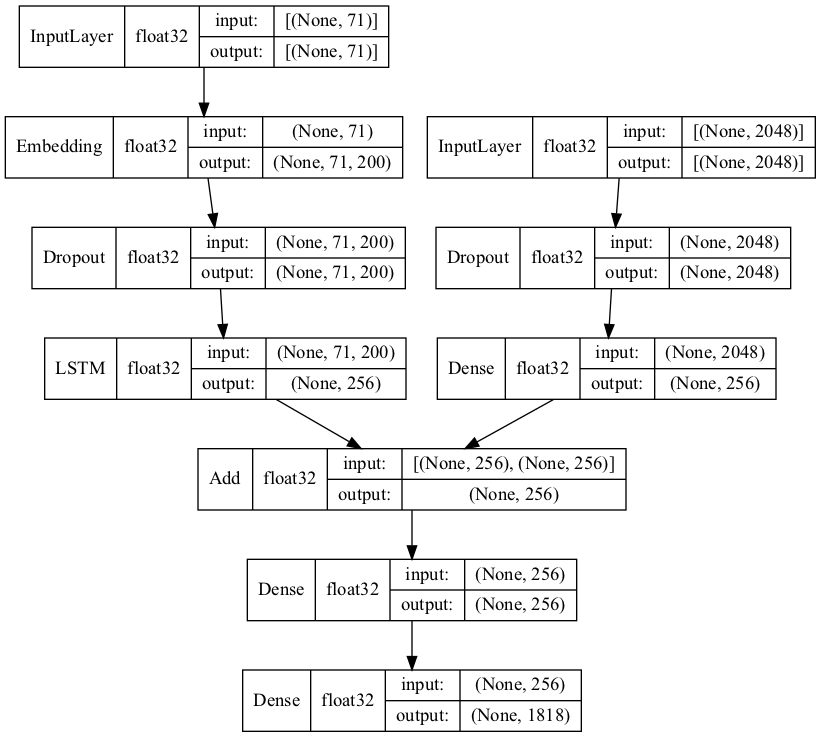

In [50]:
tf.keras.utils.plot_model(
    h_model,
    to_file="model.png",
    show_shapes = True,
    show_dtype = True,
    show_layer_names = False,
    rankdir = "TB",
    expand_nested = True,
    dpi=96,
)

#### Model summary to see exactly what its structure looks like in keras

In [51]:
h_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 71)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 71, 200)      363600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

### Model Training
#### Before training the model
we need to do:
- include embedding matrix as weghits for **Embedding** layer in the model
- since we are using our own widgets from pre-trained Glove model we will freeze them, to ensure they will not change during the gradient descent process.

In [52]:
h_model.layers[2].set_weights([embedding_matrix])
h_model.layers[2].trainable = False

#### Compiling the model

In [53]:
h_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])   

#### Start Training

start with **20** and **3** photo per batch. 

In [54]:
epochs = 20
number_pics_per_batch = 3
steps = len(all_train_val_captions) // number_pics_per_batch

In [55]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

7916/7916 [==============================] - 3284s 414ms/step - loss: 3.3272 - accuracy: 0.3318


2021-12-05 16:47:30.124265: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://40a7c601-c02b-43f5-91ea-5bd28ece0413/assets


INFO:tensorflow:Assets written to: ram://40a7c601-c02b-43f5-91ea-5bd28ece0413/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3763s 475ms/step - loss: 2.7410 - accuracy: 0.3819


INFO:tensorflow:Assets written to: ram://69852294-29b8-48f1-a70b-3f196a0192ba/assets


INFO:tensorflow:Assets written to: ram://69852294-29b8-48f1-a70b-3f196a0192ba/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3813s 482ms/step - loss: 2.5551 - accuracy: 0.4012


INFO:tensorflow:Assets written to: ram://f85b636f-7a04-48d8-b3e8-aa81274d4c21/assets


INFO:tensorflow:Assets written to: ram://f85b636f-7a04-48d8-b3e8-aa81274d4c21/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3494s 441ms/step - loss: 2.4508 - accuracy: 0.4127


INFO:tensorflow:Assets written to: ram://f0b96da4-8657-48a3-80c4-3d25c9bef411/assets


INFO:tensorflow:Assets written to: ram://f0b96da4-8657-48a3-80c4-3d25c9bef411/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3929s 496ms/step - loss: 2.3823 - accuracy: 0.4210


INFO:tensorflow:Assets written to: ram://84fcec9c-d1ca-4f69-8848-ee9648db17f3/assets


INFO:tensorflow:Assets written to: ram://84fcec9c-d1ca-4f69-8848-ee9648db17f3/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3578s 452ms/step - loss: 2.3340 - accuracy: 0.4272


INFO:tensorflow:Assets written to: ram://4a561157-1c5f-4b47-8662-6c34be838042/assets


INFO:tensorflow:Assets written to: ram://4a561157-1c5f-4b47-8662-6c34be838042/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3489s 441ms/step - loss: 2.2987 - accuracy: 0.4321


INFO:tensorflow:Assets written to: ram://19d9c2b8-54a0-497f-8d09-84f1a622d22c/assets


INFO:tensorflow:Assets written to: ram://19d9c2b8-54a0-497f-8d09-84f1a622d22c/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4519s 571ms/step - loss: 2.2688 - accuracy: 0.4364


INFO:tensorflow:Assets written to: ram://62b08d1b-99ef-43b6-aef9-69441dec7963/assets


INFO:tensorflow:Assets written to: ram://62b08d1b-99ef-43b6-aef9-69441dec7963/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4933s 623ms/step - loss: 2.2442 - accuracy: 0.4396


INFO:tensorflow:Assets written to: ram://1902444c-dba2-4849-8d3d-d9293f2eb270/assets


INFO:tensorflow:Assets written to: ram://1902444c-dba2-4849-8d3d-d9293f2eb270/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4855s 613ms/step - loss: 2.2260 - accuracy: 0.4425


INFO:tensorflow:Assets written to: ram://eeaa17d4-bfe1-4360-a78e-5779e70094b1/assets


INFO:tensorflow:Assets written to: ram://eeaa17d4-bfe1-4360-a78e-5779e70094b1/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4857s 614ms/step - loss: 2.2080 - accuracy: 0.4451


INFO:tensorflow:Assets written to: ram://2b249dc5-7e18-426b-8d29-c6d6e692809c/assets


INFO:tensorflow:Assets written to: ram://2b249dc5-7e18-426b-8d29-c6d6e692809c/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4896s 619ms/step - loss: 2.1948 - accuracy: 0.4473


INFO:tensorflow:Assets written to: ram://e0ef29a8-5ad5-40ed-bbd4-965fbd25e569/assets


INFO:tensorflow:Assets written to: ram://e0ef29a8-5ad5-40ed-bbd4-965fbd25e569/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3464s 438ms/step - loss: 2.1827 - accuracy: 0.4487


INFO:tensorflow:Assets written to: ram://5c18048e-5220-4839-9063-ec944ebda873/assets


INFO:tensorflow:Assets written to: ram://5c18048e-5220-4839-9063-ec944ebda873/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 2993s 378ms/step - loss: 2.1723 - accuracy: 0.4506


INFO:tensorflow:Assets written to: ram://1523ba18-9fee-40f7-b553-1866ede9524f/assets


INFO:tensorflow:Assets written to: ram://1523ba18-9fee-40f7-b553-1866ede9524f/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3021s 382ms/step - loss: 2.1639 - accuracy: 0.4520


INFO:tensorflow:Assets written to: ram://32c519fe-848e-429f-a2d1-be06f4e7899d/assets


INFO:tensorflow:Assets written to: ram://32c519fe-848e-429f-a2d1-be06f4e7899d/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3048s 385ms/step - loss: 2.1563 - accuracy: 0.4528


INFO:tensorflow:Assets written to: ram://579c3ef6-f98c-4b6e-9e61-5c3619092ef3/assets


INFO:tensorflow:Assets written to: ram://579c3ef6-f98c-4b6e-9e61-5c3619092ef3/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3153s 398ms/step - loss: 2.1476 - accuracy: 0.4544


INFO:tensorflow:Assets written to: ram://39de0206-352c-4796-8b23-1504912a4b3b/assets


INFO:tensorflow:Assets written to: ram://39de0206-352c-4796-8b23-1504912a4b3b/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 3022s 382ms/step - loss: 2.1403 - accuracy: 0.4556


INFO:tensorflow:Assets written to: ram://d5d7bb4f-069c-4f12-bae3-95ce263e1af2/assets


INFO:tensorflow:Assets written to: ram://d5d7bb4f-069c-4f12-bae3-95ce263e1af2/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 2957s 374ms/step - loss: 2.1359 - accuracy: 0.4562


INFO:tensorflow:Assets written to: ram://c29395c8-490c-4b95-9d8a-f62d85dced82/assets


INFO:tensorflow:Assets written to: ram://c29395c8-490c-4b95-9d8a-f62d85dced82/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 2952s 373ms/step - loss: 2.1282 - accuracy: 0.4573


INFO:tensorflow:Assets written to: ram://f1f41d1a-7ce2-4a43-859c-56be9d1297d0/assets


INFO:tensorflow:Assets written to: ram://f1f41d1a-7ce2-4a43-859c-56be9d1297d0/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


change optimizer learning rate to **0.0001** and photo per batch to **6** with 10 epochs.

In [60]:
h_model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_batch = 6

In [61]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generatbor, epochs = 1, steps_per_epoch = steps, verbose = 1 )
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

7916/7916 [==============================] - 5205s 657ms/step - loss: 2.0279 - accuracy: 0.4766


INFO:tensorflow:Assets written to: ram://aef0244c-fbb4-4436-828e-00b589f7caea/assets


INFO:tensorflow:Assets written to: ram://aef0244c-fbb4-4436-828e-00b589f7caea/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 5271s 666ms/step - loss: 1.9824 - accuracy: 0.4847


INFO:tensorflow:Assets written to: ram://efa079b6-9757-4f58-9204-33c74ef62f32/assets


INFO:tensorflow:Assets written to: ram://efa079b6-9757-4f58-9204-33c74ef62f32/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 8484s 1s/step - loss: 1.9547 - accuracy: 0.4896


INFO:tensorflow:Assets written to: ram://a6508d54-a8fc-4b1d-94de-1d598defc301/assets


INFO:tensorflow:Assets written to: ram://a6508d54-a8fc-4b1d-94de-1d598defc301/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 5223s 660ms/step - loss: 1.9347 - accuracy: 0.4930


INFO:tensorflow:Assets written to: ram://809fd2c4-2258-4ae7-8e26-65483e2d064a/assets


INFO:tensorflow:Assets written to: ram://809fd2c4-2258-4ae7-8e26-65483e2d064a/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4886s 617ms/step - loss: 1.9191 - accuracy: 0.4960


INFO:tensorflow:Assets written to: ram://44a99feb-6fcf-4f02-bb75-4dbb3acca159/assets


INFO:tensorflow:Assets written to: ram://44a99feb-6fcf-4f02-bb75-4dbb3acca159/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [62]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1 )
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

7916/7916 [==============================] - 4938s 624ms/step - loss: 1.9055 - accuracy: 0.4980


INFO:tensorflow:Assets written to: ram://4fd5738b-f543-4f4c-aec7-7e6142533f6e/assets


INFO:tensorflow:Assets written to: ram://4fd5738b-f543-4f4c-aec7-7e6142533f6e/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4988s 630ms/step - loss: 1.8931 - accuracy: 0.5006


INFO:tensorflow:Assets written to: ram://0be3853e-29f7-49ac-b91e-2fd6130ae5f5/assets


INFO:tensorflow:Assets written to: ram://0be3853e-29f7-49ac-b91e-2fd6130ae5f5/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 5010s 633ms/step - loss: 1.8828 - accuracy: 0.5028


INFO:tensorflow:Assets written to: ram://5de4ace0-bda4-41b6-b85a-2a2c378eab02/assets


INFO:tensorflow:Assets written to: ram://5de4ace0-bda4-41b6-b85a-2a2c378eab02/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4957s 626ms/step - loss: 1.8736 - accuracy: 0.5041


INFO:tensorflow:Assets written to: ram://78291a3d-971b-490d-8d00-aaea7fd0fcfd/assets


INFO:tensorflow:Assets written to: ram://78291a3d-971b-490d-8d00-aaea7fd0fcfd/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7916/7916 [==============================] - 4943s 624ms/step - loss: 1.8637 - accuracy: 0.5059


INFO:tensorflow:Assets written to: ram://94e98882-5f83-49fa-b6f0-a30076367d2c/assets


INFO:tensorflow:Assets written to: ram://94e98882-5f83-49fa-b6f0-a30076367d2c/assets
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/shahadsulaiman/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Covnert the final model into Tensorflow Lite
in order to use it in android application

In [ ]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(h_model)


converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]



tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

### Model Evaluation

In [ ]:
generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
eval_dict = h_mode.evaluate(x = generator, verbose = 1, return_dict = True)
eval_dict

In [144]:
import math
import re
from collections import Counter
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)



def get_avg_cosine(actuals, generated):
    sum_ = 0 
    for corpus in actuals:
        sum_ += get_cosine(corpus, generated)
    return sum_ / len(actuals)


def evaluate_model():
    sum_ = 0
    for i in encoding_test.keys():
        
        generated_caption_ = greedySearch(encoding_test[i].reshape((1,2048)))
        generated_caption = text_to_vector(generated_caption_)
        actual_captions = [text_to_vector(caption_test['Caption_1'][i]),\
                           text_to_vector(caption_test['Caption_2'][i]),\
                           text_to_vector(caption_test['Caption_3'][i]),\
                           text_to_vector(caption_test['Caption_4'][i]),\
                           text_to_vector(caption_test['Caption_5'][i])]
        sum_ += get_avg_cosine(actual_captions, generated_caption)
        print(get_avg_cosine(actual_captions, generated_caption))
        print(actual_captions,'==>', generated_caption)
        break
    return sum_ / len(encoding_test.keys())
evaluate_model()

0.31434375748312415
[Counter({'a': 2, 'startseq': 1, 'man': 1, 'with': 1, 'hat': 1, 'on': 1, 'as': 1, 'he': 1, 'holds': 1, 'his': 1, 'fruit': 1, 'in': 1, 'front': 1, 'of': 1, 'him': 1, 'endseq': 1}), Counter({'startseq': 1, 'an': 1, 'oriental': 1, 'woman': 1, 'in': 1, 'a': 1, 'hat': 1, 'proudly': 1, 'showing': 1, 'off': 1, 'her': 1, 'fruit': 1, 'endseq': 1}), Counter({'startseq': 1, 'an': 1, 'individual': 1, 'with': 1, 'a': 1, 'hat': 1, 'is': 1, 'holding': 1, 'some': 1, 'sort': 1, 'of': 1, 'fruit': 1, 'endseq': 1}), Counter({'a': 2, 'startseq': 1, 'man': 1, 'holding': 1, 'fresh': 1, 'fruits': 1, 'in': 1, 'front': 1, 'of': 1, 'market': 1, 'endseq': 1}), Counter({'startseq': 1, 'asian': 1, 'lady': 1, 'selling': 1, 'fruit': 1, 'endseq': 1})] ==> Counter({'a': 4, 'in': 2, 'shirt': 2, 'man': 1, 'white': 1, 'and': 1, 'black': 1, 'pants': 1, 'is': 1, 'walking': 1, 'with': 1, 'woman': 1, 'blue': 1, 'crossing': 1})


0.0012573750299324966

### Model Testing 

In [ ]:
for z in range(len(encoding_test.keys())):
    print('Pic In ==>', z)
    pic = list(encoding_test.keys())[z]
    image_ = encoding_test[pic].reshape((1,2048))
    x=plt.imread(image_path+'/'+pic)
    plt.imshow(x)
    plt.show()
    print("Caption:",greedySearch(image_))

### Best Result

In [114]:
best_result = [4,11,18,20,21,35,37,46,50]
img_paths = []
for i in best_result:
    pic = list(encoding_test.keys())[i]
    img_paths.append(image_path+pic)


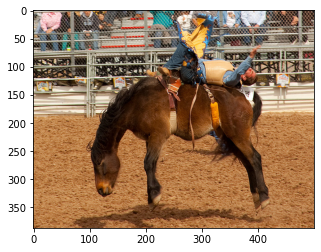

./data/images/4427058951.jpg
الوصف: رجل يرتدي قميصًا أبيض يركب حصانًا مجروحًا


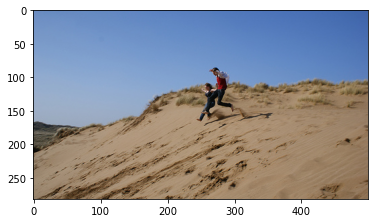

./data/images/3368368761.jpg
الوصف: رجل يرتدي قميصًا أسود وبنطلون جينز يسير على تل


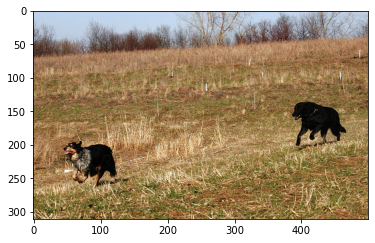

./data/images/3471066276.jpg
الوصف: كلبان يركضان عبر العشب


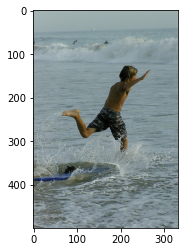

./data/images/1308617539_54e1a3dfbe.jpg
الوصف: رجل يرتدي سروال السباحة يقفز في المحيط


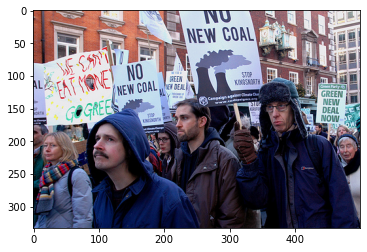

./data/images/3099091086.jpg
الوصف: امرأة ترتدي معطفًا أسود ورجلًا يرتدي سترة سوداء في مواجهة الحشد


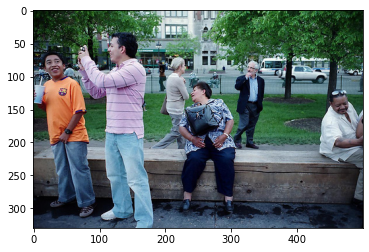

./data/images/843218288.jpg
الوصف: مجموعة من الناس تقف حول مبنى


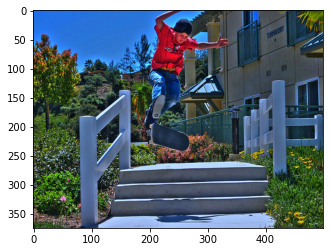

./data/images/3547368652.jpg
الوصف: لوح تزلج يتزلج على سكة حديدية


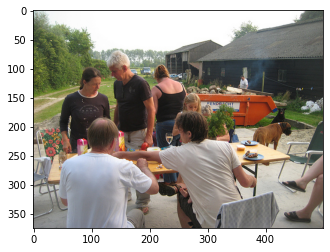

./data/images/3969506142.jpg
الوصف: مجموعة من الناس تقف حول طاولة


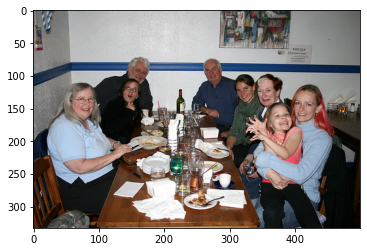

./data/images/2115112541.jpg
الوصف: مجموعة من الناس يجلسون على مائدة يأكلون الطعام


In [140]:
for path in img_paths:
    result, tmp = ar_caption(path)
    print(path)
    print(result)

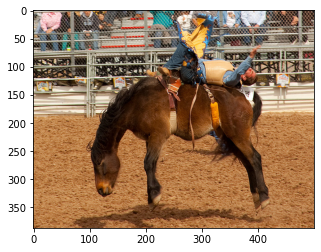

Caption: a man in a white shirt is riding a bucking horse


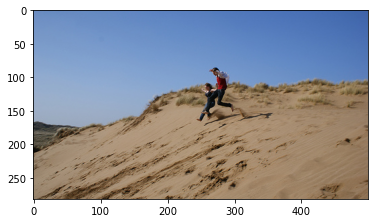

Caption: a man in a black shirt and jeans is walking on a hill


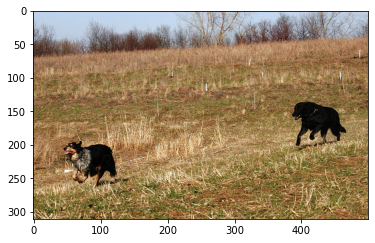

Caption: two dogs run through the grass


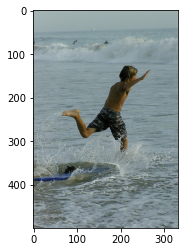

Caption: a man in swimming trunks is jumping into the ocean


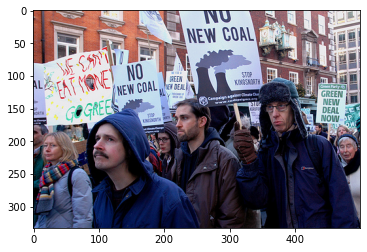

Caption: a woman in a black coat and a man in a black jacket are facing the crowd


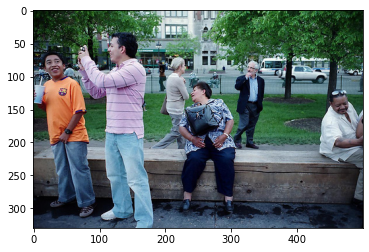

Caption: a group of people are standing around a building


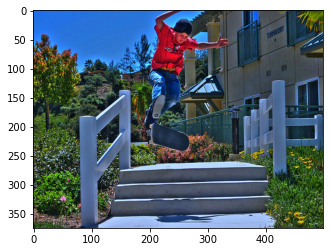

Caption: a skateboarder is skating on a rail


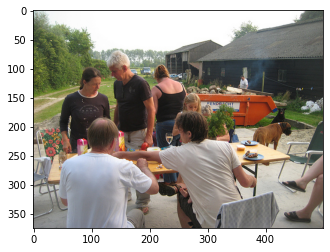

Caption: a group of people are standing around a table


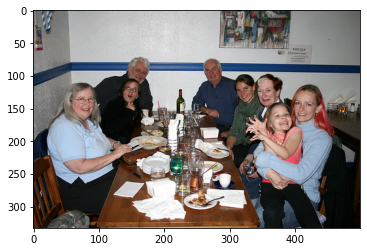

Caption: a group of people are sitting at a table eating food


In [128]:
for path in img_paths:
    result, tmp = en_caption(path)
    print(result)

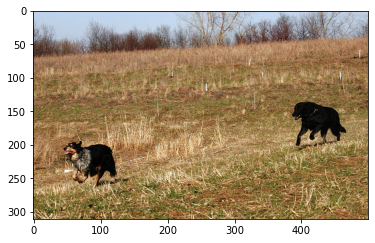

Caption: two dogs run through the grass


In [148]:
en_speech(img_paths[2])

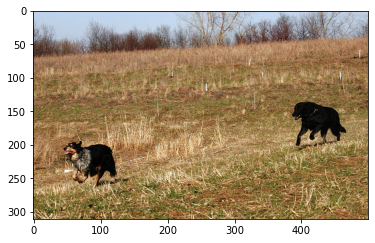

الوصف: كلبان يركضان عبر العشب


In [149]:
ar_speech(img_paths[2])